In [1]:
import jax

import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('../')

In [2]:
from datasets import sin_data
from models import gmlp
from utility import plot,fits,predict


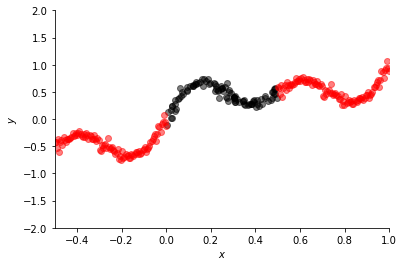

In [3]:
X,Y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [4]:
model = gmlp.GaussianMLP([16,16])

In [7]:
params_list = []
losses_list = []
for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X)
    params, loss = fits.fit(model, params, X, Y,learning_rate=0.01, epochs=1000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)



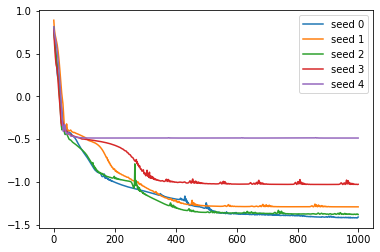

In [8]:
for i in range(5):
    plt.plot(jnp.arange(0,1000,1),losses_list[i],label='seed '+str(i))
plt.legend()

In [7]:
X  = jnp.sort(X[:,0]).reshape(100,1)
mean,sigma = predict.predict(5,model,params_list,X)
mean_lx,sigma_lx = predict.predict(5,model,params_list,x_test_1)
mean_ux,sigma_ux = predict.predict(5,model,params_list,x_test_2)

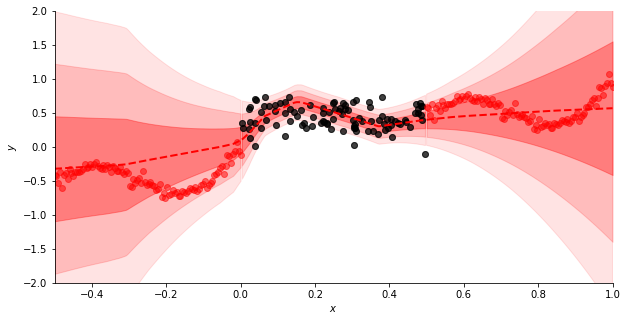

In [8]:
plt.figure(figsize=(10,5))
plt.plot(X,mean, "r--", linewidth=2)
plt.plot(x_test_1,mean_lx, "r--", linewidth=2)
plt.plot(x_test_2,mean_ux, "r--", linewidth=2)
for i_std in range(1,4):
  plt.fill_between(X.reshape(100), jnp.array((mean-i_std*sigma)), jnp.array((mean+i_std*sigma)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_1.reshape(100), jnp.array((mean_lx-i_std*sigma_lx)), jnp.array((mean_lx+i_std*sigma_lx)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_2.reshape(100), jnp.array((mean_ux-i_std*sigma_ux)), jnp.array((mean_ux+i_std*sigma_ux)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
plt.scatter(X, Y,color='black',alpha=0.5)
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

# plt.plot(X, final_mean+final_sigma)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2,2)
sns.despine()
plt.show()

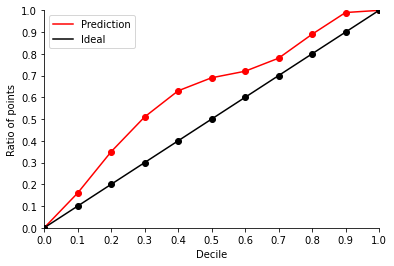

In [9]:
df = plot.calibration_regression(mean_ux,sigma_ux,y_test_2)


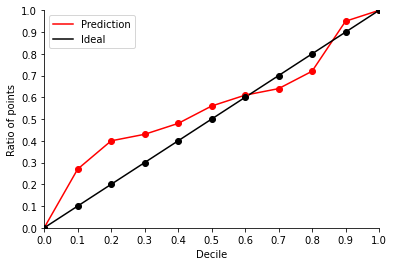

In [10]:
df = plot.calibration_regression(mean_lx,sigma_lx,y_test_1)




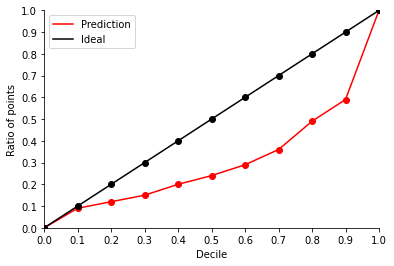

In [11]:
df = plot.calibration_regression(mean,sigma,Y)


In [10]:
seed=11
param =  model.init(jax.random.PRNGKey(seed),X)
param, los = fits.fit(model, param, X, Y,learning_rate=0.01, epochs=1000, verbose=True)



Loss step 0:  0.8032126
Loss step 100:  -0.493446
Loss step 200:  -0.5226819
Loss step 300:  -0.64161694
Loss step 400:  -1.0097756
Loss step 500:  -1.2127194
Loss step 600:  -1.3081665
Loss step 700:  -1.3425319
Loss step 800:  -1.3547115
Loss step 900:  -1.3321307


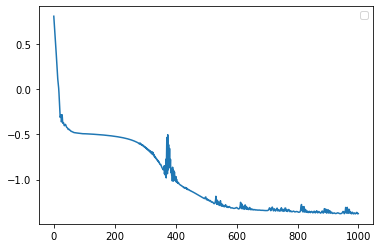

In [12]:
plt.plot(jnp.arange(0,1000,1),los)
plt.legend()

In [13]:
X  = jnp.sort(X[:,0]).reshape(100,1)
mean,sigma = model.apply(param,X)
mean_lx,sigma_lx = model.apply(param,x_test_1)
mean_ux,sigma_ux = model.apply(param,x_test_2)

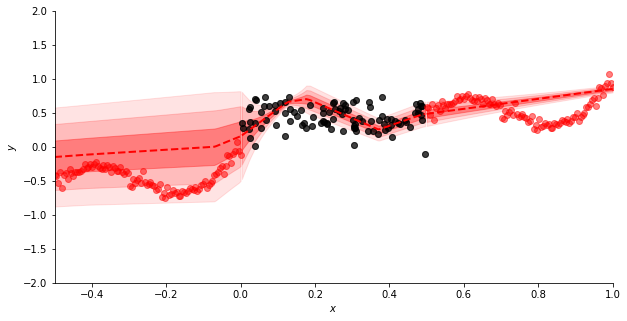

In [14]:
plt.figure(figsize=(10,5))
plt.plot(X,mean, "r--", linewidth=2)
plt.plot(x_test_1,mean_lx, "r--", linewidth=2)
plt.plot(x_test_2,mean_ux, "r--", linewidth=2)
for i_std in range(1,4):
  plt.fill_between(X.reshape(100), jnp.array((mean-i_std*sigma)), jnp.array((mean+i_std*sigma)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_1.reshape(100), jnp.array((mean_lx-i_std*sigma_lx)), jnp.array((mean_lx+i_std*sigma_lx)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
for i_std in range(1,4):
  plt.fill_between(x_test_2.reshape(100), jnp.array((mean_ux-i_std*sigma_ux)), jnp.array((mean_ux+i_std*sigma_ux)), color='red',alpha=1/(3*i_std), label='std'+str(i_std))
plt.scatter(X, Y,color='black',alpha=0.5)
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

# plt.plot(X, final_mean+final_sigma)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2,2)
sns.despine()
plt.show()

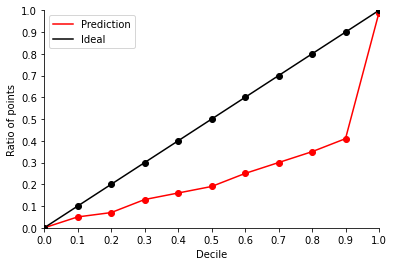

In [15]:
df = plot.calibration_regression(mean,sigma,Y)


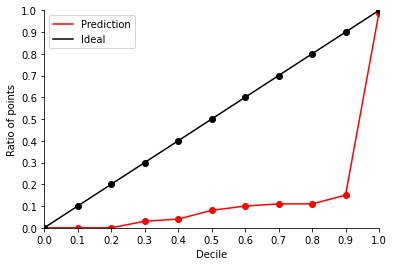

In [16]:
df = plot.calibration_regression(mean_ux,sigma_ux,y_test_2)

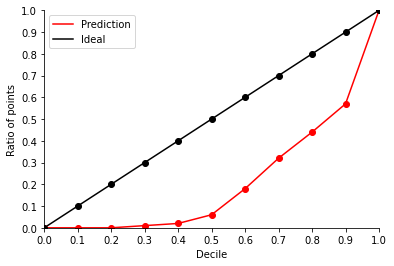

In [17]:
df = plot.calibration_regression(mean_lx,sigma_lx,y_test_1)